In [5]:
import os
os.environ['JAVA_HOME']='/usr/bin/java'

In [6]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

from capymoa.stream import Stream, Schema, NumpyStream
from capymoa.classifier import HoeffdingAdaptiveTree
from capymoa.instance import Instance, LabeledInstance
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.misc import save_model, load_model

import matplotlib.pyplot as plt

In [7]:
class DetectBusyStationsModel:
    def __init__(self, data_path_5min, data_path_30min):
        self.data_path_5min = data_path_5min
        self.data_path_30min = data_path_30min
        
        self.busy_detector = None
    
        # Busy station threshold (top 20%)
        self.busy_threshold_percentile = 80
        
        # Results storage
        self.results = None

    def _initialize_models(self):
        """
        Initialize models
        """
        
        # Features include: current boarding count, alighting count, onboard count, hour, day of week, is weekend, historical statistics, etc.
        schema = Schema.from_custom(
            feature_names=[
                "boarding", "landing", "loader",
                "hour", "day_of_week", "is_weekend",
            ],
            dataset_name="BusStop",
            target_attribute_name="is_busy",
            values_for_class_label=[0, 1]
        )

        # Initialize model
        self.busy_detector = HoeffdingAdaptiveTree(schema)  # Busy station detection

    def load_and_preprocess_data(self):
        """
        Load and preprocess 5-minute and 30-minute data
        """
        print("Loading data...")
        
        # Load 5-minute data
        self.boarding_5min = pd.read_csv(f"{self.data_path_5min}/boarding_03-05_2024.csv", index_col=0)
        self.landing_5min = pd.read_csv(f"{self.data_path_5min}/landing_03-05_2024.csv", index_col=0)
        self.loader_5min = pd.read_csv(f"{self.data_path_5min}/loader_03-05_2024.csv", index_col=0)
        
        # Load 30-minute data
        self.boarding_30min = pd.read_csv(f"{self.data_path_30min}/boarding_03-05_2024.csv", index_col=0)
        self.landing_30min = pd.read_csv(f"{self.data_path_30min}/landing_03-05_2024.csv", index_col=0)
        self.loader_30min = pd.read_csv(f"{self.data_path_30min}/loader_03-05_2024.csv", index_col=0)
        
        # Convert time index
        for df in [self.boarding_5min, self.landing_5min, self.loader_5min]:
            df.index = pd.to_datetime(df.index)
            
        for df in [self.boarding_30min, self.landing_30min, self.loader_30min]:
            df.index = pd.to_datetime(df.index)
        
            
        # Get station list
        self.stations = list(self.boarding_5min.columns)
        print(f"Loading complete, total {len(self.stations)} stations")
        
        # Create data schema and initialize models
        self._initialize_models()

    def extract_features(self, timestamp, station, data_type='5min'):
        """
        Extract features for machine learning model
        """
        features = []
        
        if data_type == '5min':
            boarding_df = self.boarding_5min
            landing_df = self.landing_5min
            loader_df = self.loader_5min
        else:
            boarding_df = self.boarding_30min
            landing_df = self.landing_30min
            loader_df = self.loader_30min
            
        # Current time period data
        current_boarding = boarding_df.loc[timestamp, station] if timestamp in boarding_df.index else 0
        current_landing = landing_df.loc[timestamp, station] if timestamp in landing_df.index else 0
        current_loader = loader_df.loc[timestamp, station] if timestamp in loader_df.index else 0
        
        features.extend([current_boarding, current_landing, current_loader])
        
        # Time features
        hour = timestamp.hour
        day_of_week = timestamp.weekday()
        is_weekend = 1 if day_of_week >= 5 else 0
        
        features.extend([hour, day_of_week, is_weekend])
        
        return np.array(features)
    
    def detect_busy_stations(self, timestamp, data_type='5min'):
        """
        Detect busy stations for current time period
        """
        if data_type == '5min':
            loader_df = self.loader_5min
        else:
            loader_df = self.loader_30min
            
        if timestamp not in loader_df.index:
            return []
            
        total_passengers = loader_df.loc[timestamp]
    
        # Calculate mean and standard deviation
        mean_passengers = total_passengers.mean()
        std_passengers = total_passengers.std()
        
        # Absolute minimum threshold
        min_threshold = 100
        
        # Z-score > 1.5 and passenger load > minimum threshold
        z_scores = (total_passengers - mean_passengers) / (std_passengers + 1e-6)
        busy_stations = total_passengers[
            (z_scores > 1.5) & (total_passengers > min_threshold)
        ].index.tolist()
        
        return busy_stations
    def train_models_online(self, data_type='5min'):
        """
        Train models online
        """
        print(f"Starting online model training - Data type: {data_type}")

        # with open("detect_busy_station_model.pkl", "rb") as f:
        #     restored_learner = load_model(f)

        # if(restored_learner is not None):
        #     self.busy_detector = restored_learner
        #     print("Model successfully restored")
        #     return
        
        if data_type == '5min':
            timestamps = self.boarding_5min.index
        else:
            timestamps = self.boarding_30min.index
            
        training_count = 0
        
        for i, timestamp in enumerate(timestamps[:-1]):  # Keep last timestamp for testing
            if i % 1000 == 0:
                print(f"Processing progress: {i}/{len(timestamps)}")  
                    
            # Get busy stations for current period (as labels)
            busy_stations = self.detect_busy_stations(timestamp, data_type)
            
            for station in self.stations:
                # Extract features
                features = self.extract_features(timestamp, station, data_type)
                
                # Busy station detection label
                is_busy = 1 if station in busy_stations else 0
                
                # Online classifier training
                busy_detector_instance = LabeledInstance.from_array(self.busy_detector.schema, features, is_busy)
                self.busy_detector.train(busy_detector_instance)

                training_count += 1
        
        print(f"Training complete, trained {training_count} samples")

        # Evaluate model performance
        self.evaluate_model_performance(X_instances, y_instances)
        
    def evaluate_model_performance(self, data_type='5min'):
        """
        Evaluate model performance using prequential evaluation and plot results
        """

        stream = self.create_stream_from_data(data_type)

        # Perform prequential evaluation
        results = prequential_evaluation(
            stream=stream,
            learner=self.busy_detector,
            window_size=1000  # Calculate metrics every 1000 samples
        )

        print(f"Accuracy: {results['cumulative'].accuracy():.3f}")

        save_model(self.busy_detector, "detect_busy_station_model.pkl")

        print("\n\tAll the windowed results:")
        display(results.metrics_per_window())

        # Plot evaluation results
        plot_windowed_results(
            results, 
            metric="accuracy", 
            xlabel="Instances", 
            ylabel="Accuracy",
        )

    def create_stream_from_data(self, data_type='5min'):
        """
        Create a stream object from existing data for prequential evaluation
        """
        
        if data_type == '5min':
            timestamps = self.boarding_5min.index
        else:
            timestamps = self.boarding_30min.index
            
        training_count = 0

        # Create instance lists
        X_instances = []
        y_instances = []
        
        for i, timestamp in enumerate(timestamps[:-1]):  # Keep last timestamp for testing
            if i % 1000 == 0:
                print(f"Processing progress: {i}/{len(timestamps)}")  
                    
            # Get busy stations for current period (as labels)
            busy_stations = self.detect_busy_stations(timestamp, data_type)
            
            for station in self.stations:
                # Extract features
                features = self.extract_features(timestamp, station, data_type)
                
                # Busy station detection label
                is_busy = 1 if station in busy_stations else 0
                
                X_instances.append(features)
                y_instances.append(is_busy)
                
                training_count += 1
        
        print(f"{training_count} samples")
        
        # Create stream object
        X_array = np.array(X_instances)
        y_array = np.array(y_instances)

        stream = NumpyStream(X_array, y_array)
        return stream

Loading data...
Loading complete, total 10 stations
Processing progress: 0/21840
Processing progress: 1000/21840
Processing progress: 2000/21840
Processing progress: 3000/21840
Processing progress: 4000/21840
Processing progress: 5000/21840
Processing progress: 6000/21840
Processing progress: 7000/21840
Processing progress: 8000/21840
Processing progress: 9000/21840
Processing progress: 10000/21840
Processing progress: 11000/21840
Processing progress: 12000/21840
Processing progress: 13000/21840
Processing progress: 14000/21840
Processing progress: 15000/21840
Processing progress: 16000/21840
Processing progress: 17000/21840
Processing progress: 18000/21840
Processing progress: 19000/21840
Processing progress: 20000/21840
Processing progress: 21000/21840
218390 samples
Accuracy: 98.484

	All the windowed results:


,instances,accuracy,kappa,kappa_t,kappa_m,f1_score,f1_score_0,f1_score_1,precision,precision_0,precision_1,recall,recall_0,recall_1
0,1000.0,98.8,93.505861,93.548387,88.349515,96.752930,99.331104,94.174757,96.752930,99.331104,94.174757,96.752930,99.331104,94.174757
1,2000.0,96.1,79.238091,80.500000,68.292683,90.464212,97.822446,81.339713,97.339830,95.842451,98.837209,84.495833,99.885975,69.105691
2,3000.0,98.5,87.200492,85.294118,75.409836,93.615285,99.200000,88.000000,92.648237,99.358974,85.937500,94.602734,99.041534,90.163934
3,4000.0,99.9,99.441964,99.500000,99.000000,99.721758,99.944475,99.497487,99.944506,99.889012,100.000000,99.500000,100.000000,99.000000
4,5000.0,99.7,94.582882,95.000000,90.000000,97.362661,99.845600,94.736842,99.845838,99.691675,100.000000,95.000000,100.000000,90.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,215000.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
215,216000.0,97.8,83.543035,80.701754,71.428571,91.896489,98.814655,84.722222,94.664939,98.285102,91.044776,89.285363,99.349946,79.220779
216,217000.0,98.8,83.164983,81.250000,64.705882,91.742070,99.376947,83.783784,88.593750,99.687500,77.500000,95.122397,99.068323,91.176471
217,218000.0,96.8,34.455778,33.333333,-3.225806,68.013068,98.358974,36.000000,72.562906,97.757390,47.368421,64.000133,98.968008,29.032258


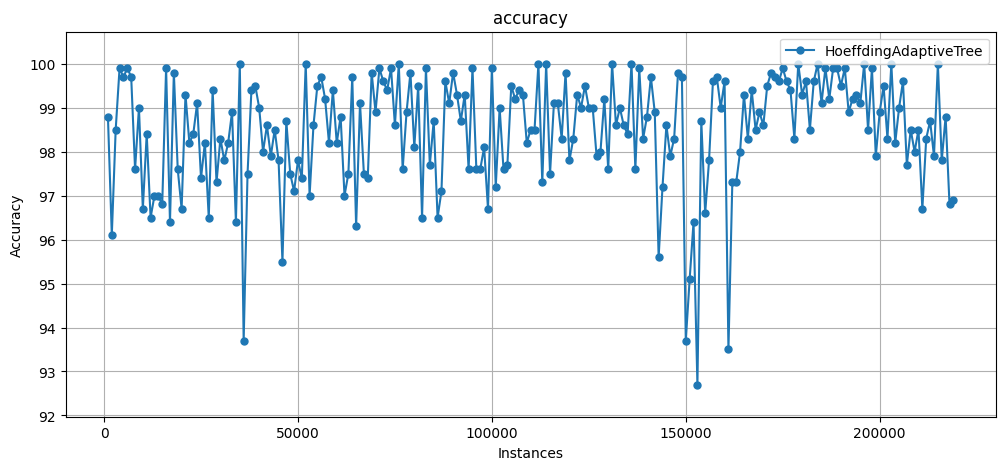

In [8]:
# Data paths
data_path_5min = "./SSA_StopBusTimeSeries_5"
data_path_30min = "./SSA_StopBusTimeSeries_30"

# Create recommendation system
model = DetectBusyStationsModel(data_path_5min, data_path_30min)

# Load data
model.load_and_preprocess_data()

model.evaluate_model_performance('5min')